### **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, roc_curve, average_precision_score)

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
# import shap
# import joblib

### ***Loading dataset***

In [3]:
#dataset
df = pd.read_csv("creditcard.csv")

print("Dataset Shape:", df.shape)
print("Missing Values:", df.isnull().sum().sum())
print()
print("Class Distribution:\n", df['Class'].value_counts())

Dataset Shape: (284807, 31)
Missing Values: 0

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


### **EDA**

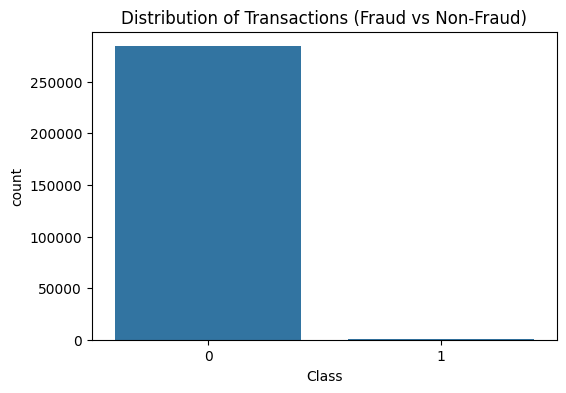

In [4]:
#Target class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Class")
plt.title("Distribution of Transactions (Fraud vs Non-Fraud)")
plt.show()

#noted that the target classes are imbalanced

In [5]:
# Fraud ratio
total = len(df)
fraud_ratio = df['Class'].mean() * 100
print(f"Fraud ratio: {fraud_ratio:.4f}%")

Fraud ratio: 0.1727%


In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

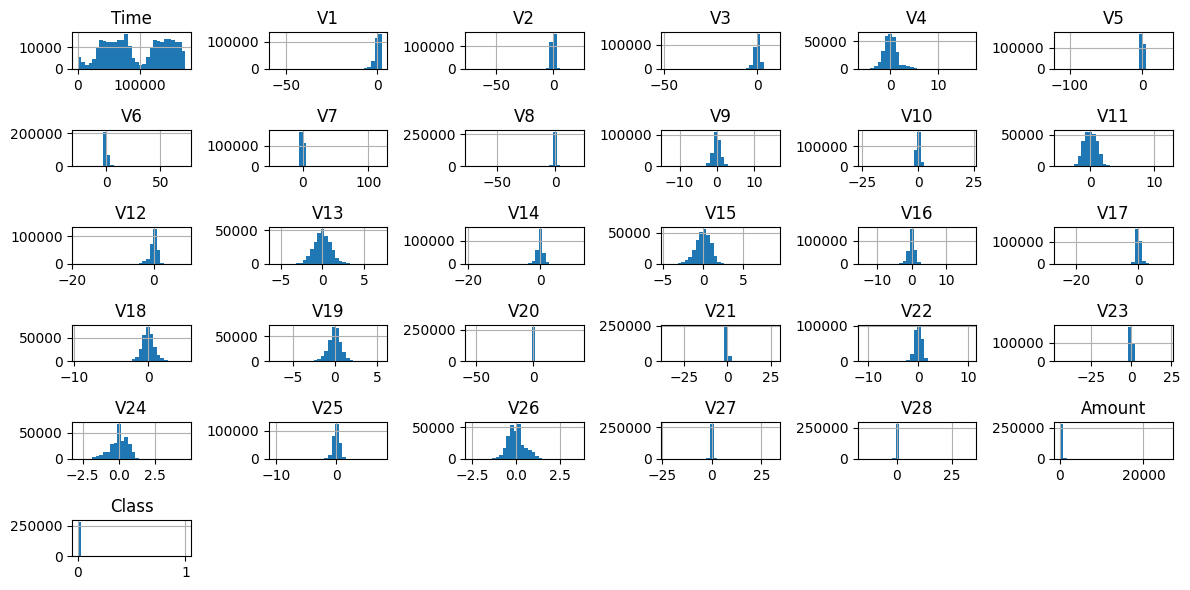

In [8]:
#Histogram
df.hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

### ***Insights***
**for the v 1-28 range,i would want that v1-v28 except for v4, v9, v11, v13, v15, v18, v19,v26 have robust scaler and the exceptions have standard scaler**


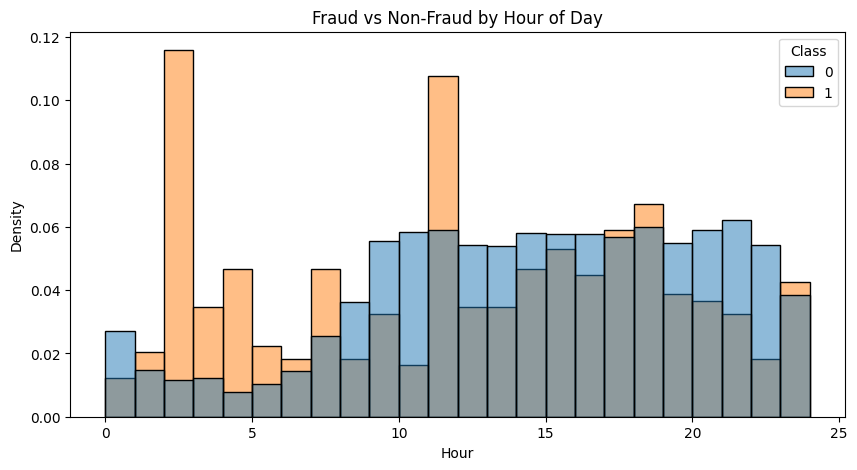

In [9]:
# Temporal fraud pattern (Hour of Day)
df['Hour'] = (df['Time'] / 3600) % 24
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='Hour', hue='Class', bins=24, kde=False, stat='density', common_norm=False)
plt.title("Fraud vs Non-Fraud by Hour of Day")
plt.show()

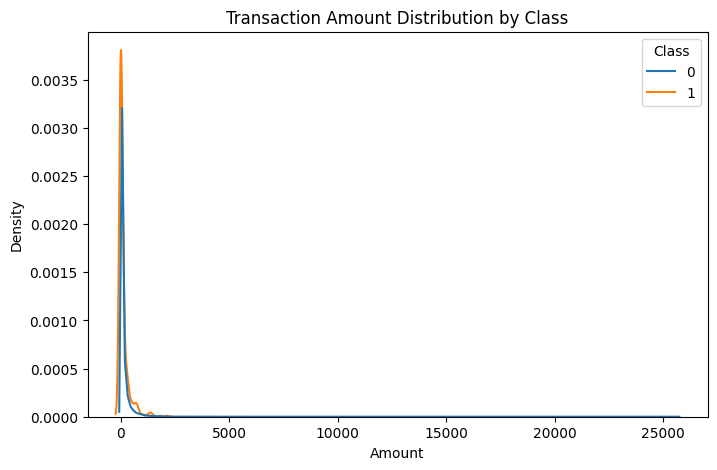

In [10]:
# Amount distribution by Class
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="Amount", hue="Class", fill=False, common_norm=False, log_scale=False)
plt.title("Transaction Amount Distribution by Class")
plt.show()

Text(0, 0.5, 'Transaction Amount (log scale)')

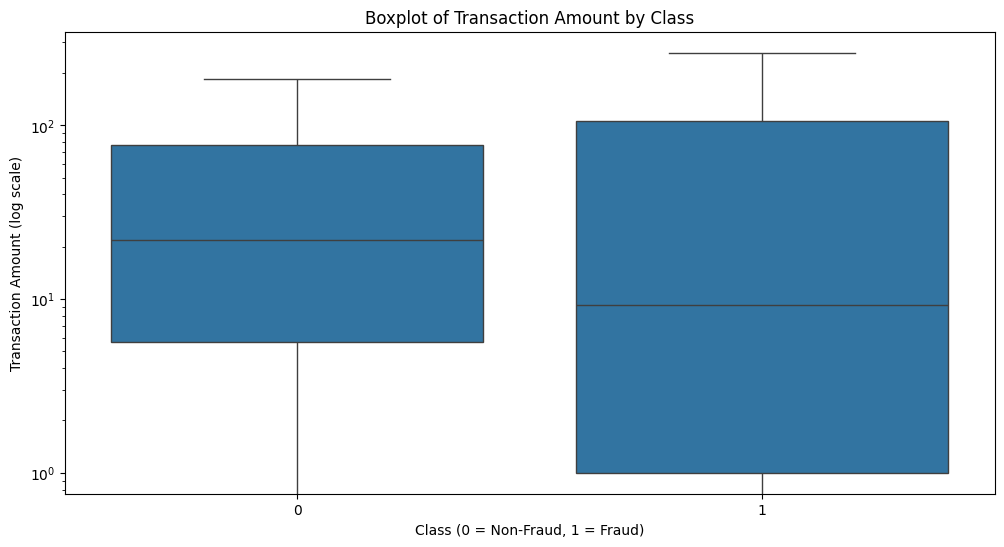

In [11]:
# Boxplot - Amount by Class
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Class", y="Amount", showfliers=False)  # hide extreme outliers for clarity
plt.yscale("log")  # log scale for skewed amounts
plt.title("Boxplot of Transaction Amount by Class")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount (log scale)")


Text(0, 0.5, 'Transaction Amount (log scale)')

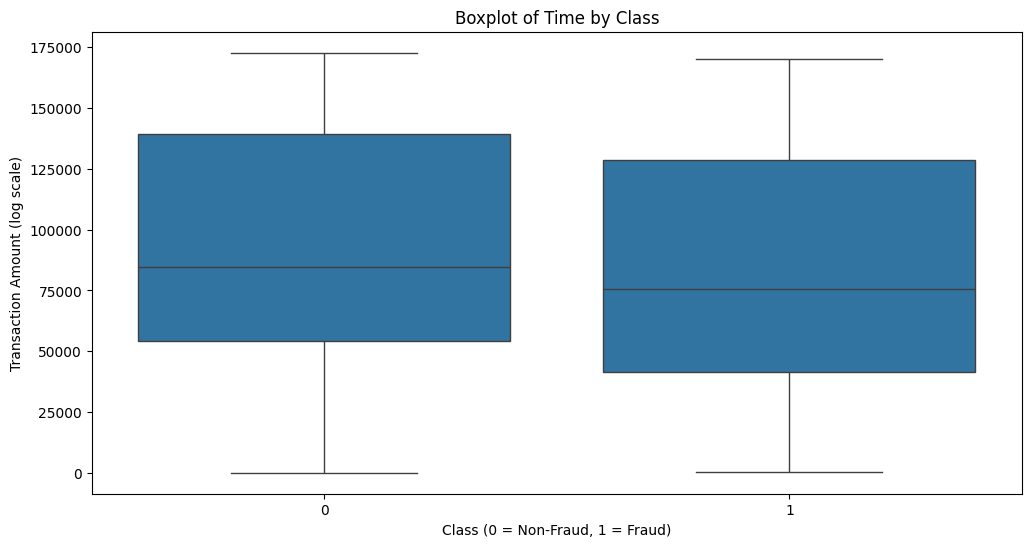

In [12]:
# Boxplot - Time by Class
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Class", y="Time", showfliers=False)  # hide extreme outliers for clarity
#plt.yscale("log")  # log scale for skewed amounts
plt.title("Boxplot of Time by Class")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount (log scale)")


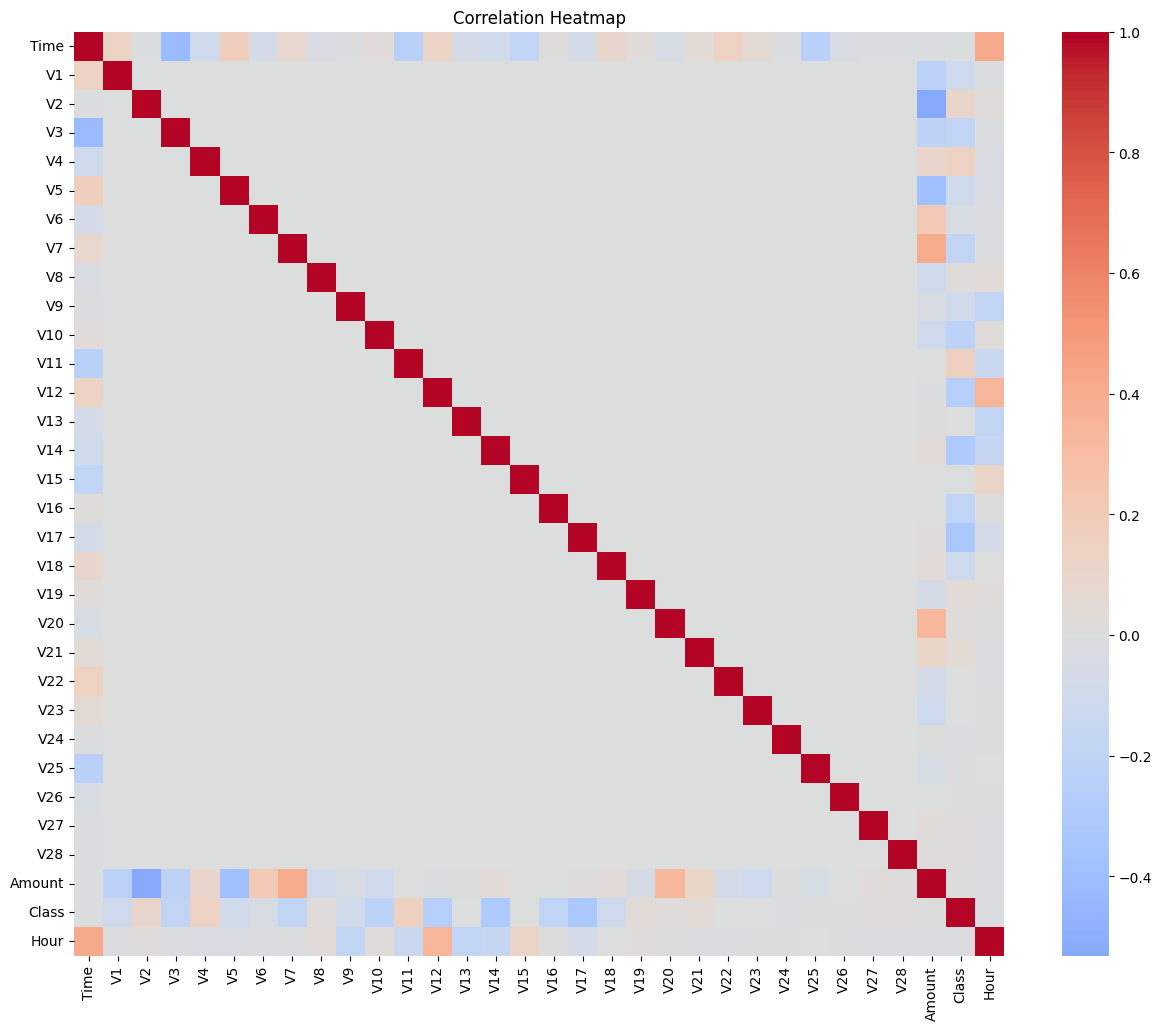

In [13]:
# Correlation heatmap
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

### **Data preprocessing**

In [14]:
# Define columns
time_col = ["Time"]
amount_col = ["Amount"]

robust_cols = [f"V{i}" for i in range(1, 29) 
               if i not in [4, 9, 11, 13, 15, 18, 19, 26]]

standard_cols = [f"V{i}" for i in [4, 9, 11, 13, 15, 18, 19, 26]]

# Build column transformer
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("time", MinMaxScaler(), time_col),
        ("amount", RobustScaler(), amount_col),
        ("robust", RobustScaler(), robust_cols),
        ("standard", StandardScaler(), standard_cols),
    ],
    remainder="passthrough"  # keep other cols if any
)

In [15]:
#defining the features
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### ***Resampling Strategies***

In [16]:
resamplers = {
    #'RandomOverSampler': RandomOverSampler(sampling_strategy=0.2, random_state=42),
    'RandomUnderSampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42),
    'SMOTE': SMOTE(sampling_strategy=0.2, random_state=42),
    #'ADASYN': ADASYN(sampling_strategy=0.2, random_state=42),
    #'SMOTEENN': SMOTEENN(random_state=42),
    #'SMOTETomek': SMOTETomek(random_state=42)
}

### ***Model Training Function***

In [17]:
def evaluate_model(name, sampler, X_train, y_train, X_test, y_test):
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    model = RandomForestClassifier(random_state=42, n_estimators=200, class_weight="balanced")
    model.fit(X_res, y_res)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    print(f"{name}")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}\n")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend(); plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (ROC-AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(); plt.show()
    
    return model


### ***Train with Different Resampling Methods***

RandomUnderSampler
              precision    recall  f1-score   support

           0     0.9998    0.9845    0.9921     56864
           1     0.0908    0.8980    0.1649        98

    accuracy                         0.9844     56962
   macro avg     0.5453    0.9412    0.5785     56962
weighted avg     0.9983    0.9844    0.9907     56962

ROC-AUC: 0.9756, PR-AUC: 0.6915



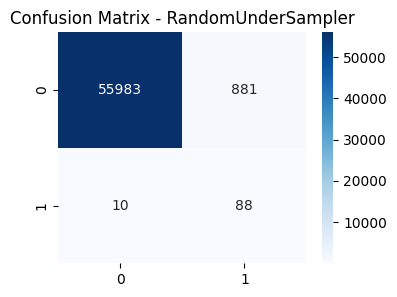

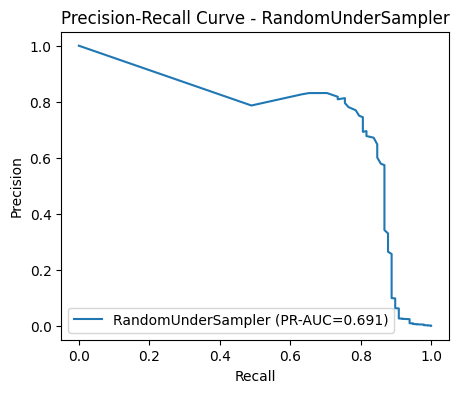

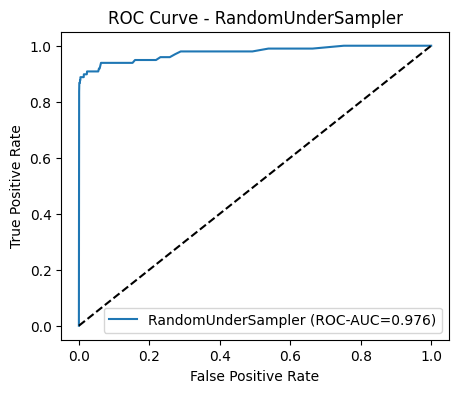

SMOTE
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8438    0.8265    0.8351        98

    accuracy                         0.9994     56962
   macro avg     0.9217    0.9131    0.9174     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9679, PR-AUC: 0.8717



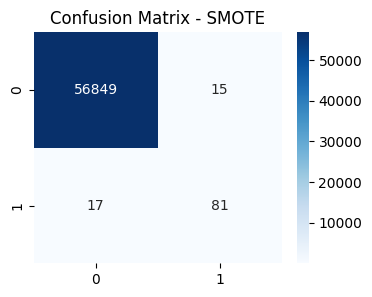

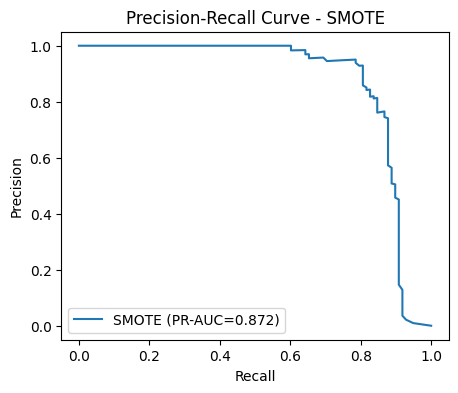

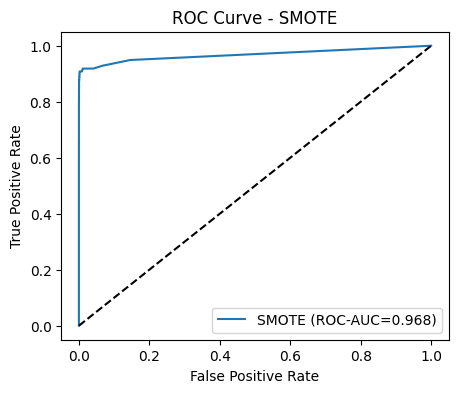

In [18]:

trained_models = {}
for name, sampler in resamplers.items():
    trained_models[name] = evaluate_model(name, sampler, X_train, y_train, X_test, y_test)
#Tries each resampling strategy, evaluates it, and stores the trained model in a dictionary to be used again if needed


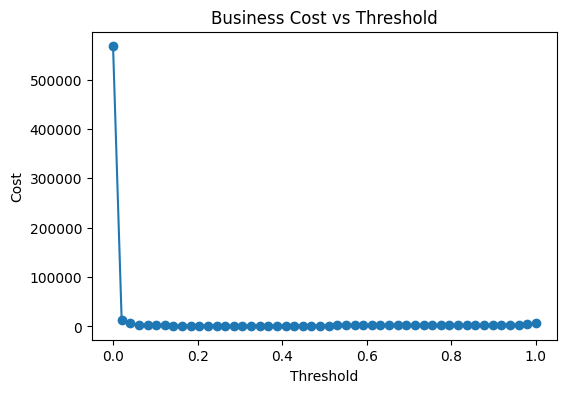

    Threshold  TP  FP  FN     TN  Cost
15   0.306122  86  30  12  56834  1500
14   0.285714  86  33  12  56831  1530
16   0.326531  85  27  13  56837  1570
13   0.265306  86  39  12  56825  1590
17   0.346939  84  26  14  56838  1660


In [19]:
# Threshold Tuning & Cost Analysis

def threshold_tuning(model, X_test, y_test, fraud_cost=100, false_alarm_cost=10):
    y_prob = model.predict_proba(X_test)[:,1]
    thresholds = np.linspace(0,1,50)
    results = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = fn*fraud_cost + fp*false_alarm_cost
        results.append((t, tp, fp, fn, tn, cost))
    results_df = pd.DataFrame(results, columns=["Threshold","TP","FP","FN","TN","Cost"])
    plt.figure(figsize=(6,4))
    plt.plot(results_df["Threshold"], results_df["Cost"], marker='o')
    plt.xlabel("Threshold"); plt.ylabel("Cost")
    plt.title("Business Cost vs Threshold")
    plt.show()
    return results_df

best_model = trained_models['SMOTE']
results_df = threshold_tuning(best_model, X_test, y_test)
print(results_df.sort_values("Cost").head())

### ***another wholly inclusive way***

In [20]:
#define resamplers
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

resamplers2 = {
    "No Resampling": None,  # baseline, train directly on imbalanced data
    "SMOTE": SMOTE(random_state=42),
    #"RandomOverSampler": RandomOverSampler(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
}


In [21]:
#define models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "RandomForest": RandomForestClassifier(
        random_state=42, n_estimators=200, class_weight="balanced"
    ),
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    #"SVM": SVC(probability=True, class_weight="balanced"),
    #"XGBoost": XGBClassifier(
        #random_state=42, scale_pos_weight=10, use_label_encoder=False, eval_metric="logloss"
    #),
}

In [22]:
#evaluate model fxn
def evaluate_model(model, name, sampler, X_train, y_train, X_test, y_test):
    
    # resample train
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    #  fit
    model.fit(X_res, y_res)
    
    results = {}
    
    # Helper function for metrics
    def get_metrics(X, y, dataset_name):
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:,1]
        cm = confusion_matrix(y, y_pred)
        roc_auc = roc_auc_score(y, y_prob)
        pr_auc = average_precision_score(y, y_prob)
        
        print(f"\n{name} - {dataset_name}")
        print(classification_report(y, y_pred, digits=4))
        print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
        
        return {"roc_auc": roc_auc, "pr_auc": pr_auc, "cm": cm}
    
    #evaluate on both train and test data
    results["train"] = get_metrics(X_res, y_res, "Train")
    results["test"]  = get_metrics(X_test, y_test, "Test")
    
    # Return model and metrics
    return {"model": model, "results": results}


In [ ]:
#call fxn for the diff resamplers and models
results = {}

for sampler_name, sampler in resamplers2.items():
    for model_name, model in models.items():
        run_name = f"{model_name} + {sampler_name}"
        results[run_name] = evaluate_model(
            model, run_name, sampler, X_train, y_train, X_test, y_test
        )



RandomForest + No Resampling - Train
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    227451
           1     1.0000    1.0000    1.0000       394

    accuracy                         1.0000    227845
   macro avg     1.0000    1.0000    1.0000    227845
weighted avg     1.0000    1.0000    1.0000    227845

ROC-AUC: 1.0000, PR-AUC: 1.0000

RandomForest + No Resampling - Test
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9610    0.7551    0.8457        98

    accuracy                         0.9995     56962
   macro avg     0.9803    0.8775    0.9227     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC: 0.9521, PR-AUC: 0.8604


c:\Users\Yvonne\Desktop\DATA SCIENCE\machine_learning\week4\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogReg + No Resampling - Train
              precision    recall  f1-score   support

           0     0.9999    0.9687    0.9840    227451
           1     0.0491    0.9340    0.0933       394

    accuracy                         0.9686    227845
   macro avg     0.5245    0.9513    0.5387    227845
weighted avg     0.9982    0.9686    0.9825    227845

ROC-AUC: 0.9864, PR-AUC: 0.7358

LogReg + No Resampling - Test
              precision    recall  f1-score   support

           0     0.9998    0.9678    0.9836     56864
           1     0.0464    0.9082    0.0882        98

    accuracy                         0.9677     56962
   macro avg     0.5231    0.9380    0.5359     56962
weighted avg     0.9982    0.9677    0.9820     56962

ROC-AUC: 0.9699, PR-AUC: 0.7217


In [ ]:
#results combined
summary = pd.DataFrame([
    {
        "Model+Resampling": name,
        "Train ROC-AUC": res["results"]["train"]["roc_auc"],
        "Train PR-AUC": res["results"]["train"]["pr_auc"],
        "Test ROC-AUC": res["results"]["test"]["roc_auc"],
        "Test PR-AUC": res["results"]["test"]["pr_auc"]
    }
    for name, res in results.items()
])

summary

In [ ]:
# Sort by best Test PR-AUC (most relevant for imbalanced problems)
summary = summary.sort_values("Test PR-AUC", ascending=False)

# Display neatly
summary.reset_index(drop=True, inplace=True)
summary